In this notebook, I use **vgg19** pre-trained model to do artistic style transfer.

The idea of artistic style transfer is to obtain a representation of the style of an input image and apply the style to another image while keeping the original image content recognizable.

## Dependencties

In [3]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


## Define Constants

In [4]:
# image file path
CONTENT_IMG_PATH= 'glass_church.jpg'
STYLE_IMG_PATH = 'oil.jpg'
# if want to keep tarining a previous image, change CONTENT_IMG_PATH to the previous image path
START_IMG_PATH = CONTENT_IMG_PATH 

# Number of iterations to run
ITER = 10

# Weights of losses
CONTENT_WEIGHT = 2 
STYLE_WEIGHT = 10
TV_WEIGHT = 0.1

# Define the shape of the otput image
w, h = load_img(CONTENT_IMG_PATH).size
print('content_img width and height:', w,h)
img_h = 400
img_w = int(w * img_h / h)
print('gen_img width and height:', img_w, img_h)

content_img width and height: 660 371
gen_img width and height: 711 400


## Visualize content and style image

In [4]:
def visualize_image(img_path):
    """
    Vidualize the input image
    Parameters: 
     img_path: a string_valued file path to an image
    Return: 
     None
    """
    img = plt.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.title(img.shape)
    plt.imshow(img);

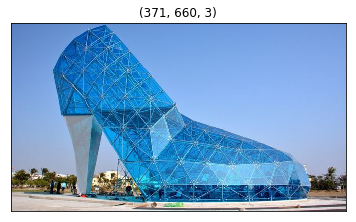

In [5]:
visualize_image(CONTENT_IMG_PATH)

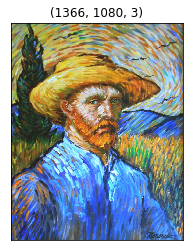

In [6]:
visualize_image(STYLE_IMG_PATH)

## Pre-process the Image

When using Tensorflow as backend, Keras CNN require a 4D tensor as input, with shape

                 (nb_samples, rows, columns, channels)
                 
- `nb_samples`: total number of images.
- `rows, columns, channels`: the number of rows, columns, channels for the image respectively.

In [11]:
def preprocess(img_path):
    """
    Preprocesses a tensor or Numpy array encoding a batch of images.
    Parameters: 
     img_path: a string_valued file path to an image
    Return: 
     img: a preprocessed 4D tensor
    """
    # loads RGB image from img_path
    img = load_img(img_path)
    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape array to 3D tensor
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # convert 3D tensor to 4D tensor 
    img = np.expand_dims(img, axis=0)
    # prepare the image for the VGG model
    img = vgg19.preprocess_input(img)
    return img

In [12]:
# Check image shape
img = preprocess(CONTENT_IMG_PATH)
print(img.shape)

(1, 400, 711, 3)


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


## Build the model

The input_tensor's shape is (3, height, width, channels or filters).

    * input_tensor[0]: content_img
    * input_tensor[1]: the style_img
    * input_tensor[2]: the gen_img

In [8]:
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# combines three arrays into a single array 
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [9]:
# we are only interested in the convolutional layers which are the feature extraction layers =>
# include_top=False
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 400, 711, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 711, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 711, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 355, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 355, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 355, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 177, 128)        0         
__________

<img src="assets/vgg19.jpg" alt="vgg19 architecture">

## Calculate losses

### 1. Content loss

The content loss is the Mean Squared Error of the feature activation in the content image and the generated image.

<img src='assets/content_loss.png' width='400px'>

In [10]:
def calc_content_loss(outputs_dict, content_layer_names):
     """
    Compute content loss which is the squared-error loss between the content image’s features 
    and generate image’s features 
    Parameters: 
     outputs_dict: a dictionary including all layers output in the model. 
                   key is layer's name and value is its output.
     content_layer_names: layers in the model which you want to calcuate the difference between the
                          two feature representations
    Return: 
     loss: calculated content loss
    """
    loss = 0. # initialize loss
    for name in content_layer_names:
        layer_features = outputs_dict[name]
        content_img_features = layer_features[0, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        loss += K.sum(K.square(gen_img_features - content_img_features))/len(content_layer_names)
    return loss

In [11]:
content_layer_names = ['block5_conv2']
content_loss = calc_content_loss(outputs_dict, content_layer_names)

### 2. Style loss

####   Gram Matrix
- the correlations between the different filter responses

<img src='assets/gram_matrix.png' width='300px'>
<img src='assets/gram_matrix.001.jpg' width='600px'>
<img src='assets/gram_matrix.002.jpg' width='600px'>
<img src='assets/gram_matrix.003.jpg' width='600px'>

####  Style loss
- the Squared Error for the Gram-matrices in the style layers.



<img src='assets/style_loss.png' width='400px'>

When style features and generated features have similar Gram matrices, they have similar styles.

In [12]:
def gram_matrix(x):
    """
    Measure the feature correlations between channels/filters
    Parameters: 
     x: features
    Return:
     gram: gram matrix
    """
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def calc_style_loss(outputs_dict, feature_layer_names):
    """
    Calculate style loss which is mean-squared distance between the entries of the gram matrix from the original image 
    and the gram matrix of the image to be generated.
    Parameters: 
     outputs_dict: a dictionary including all layers output
     feature_layer_names: layers in the model which you want to match the style representations
    Return: 
     loss: calcuated style loss
    """
    style_loss = 0.
    for name in feature_layer_names:
        layer_features = outputs_dict[name]
        style_features = layer_features[1, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        
        assert K.ndim(style_features) == 3
        assert K.ndim(gen_img_features) == 3
        S = gram_matrix(style_features)
        G = gram_matrix(gen_img_features)
        channels = 3
        size = img_h * img_w
        style_loss += (K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2)))/len(feature_layer_names)
    return style_loss

In [13]:
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_loss = calc_style_loss(outputs_dict, feature_layer_names)

### 3. Total variance loss

The total variance loss is the difference between the neighboring pixel values.

Penalize wiggles or variation in the pixel values to smooth the generated image. 

In [14]:
def total_variation_loss(x):
    """
    Compute the difference between the neighboring pixel values. 
    Parameters: 
     x: the tensor of generated image
    Return: 
     loss: calcuated total variation loss
    """
    assert K.ndim(x) == 4
    row_diff = K.square(x[:,:-1,:-1,:] - x[:,1:  , :-1,:])
    col_diff = K.square(x[:,:-1,:-1,:] - x[:, :-1,1:  ,:])
    return K.sum(K.pow(row_diff + col_diff, 1.25))

In [15]:
variation_loss= total_variation_loss(gen_img)
loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss + TV_WEIGHT * variation_loss

## Evaluating the gradients and loss

In [16]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)


def eval_loss_and_grads(x):
    """
    Evaluate the gradients and loss
    Parameters: 
     x: the tensor of generated image
    Return: 
     loss_value: loss value
     grad_values: gradients
    """
    x = x.reshape((1, img_h, img_w, 3))

    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Deprocess the image

Do the reverse of the preprocessing to display the generated image.

According to [imagenet_utils.py](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py), all pixel values in the input images were substracted by mean pixels. Therefore, the intensities are centered at zero. It will help to increase training speed and accuracy.


We need to add the mean pixel value back for each pixel in each channel before outputing the generated image.

 
```python
# function in imagenet_utils.py
def _preprocess_numpy_input(x, data_format, mode, **kwargs):

    backend, _, _, _ = get_submodules_from_kwargs(kwargs)
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x
```

In [17]:
def unprocess_image(img):
    """
    Deprocess generated image
    Parameters: 
     img: the tensor of generated image
    Return: 
     img: deprocessed image
    """
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        # tf as backend: batch, height, width, depth
        img = img.reshape((img_h, img_w, 3))
    # Remove zero-center by mean pixel
    # BGR_MEAN = [103.939, 116.779, 123.68]
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Train and Run the model

In [18]:
def train(save_weights_path):
    """
    Train the model
    Parameters: 
     save_weights_path: file path for saved weights
    Return: 
     None
    """
    evaluator = Evaluator()
    #start_img
    x = preprocess(START_IMG_PATH)
    result_prefix = 'gen_img'
    for i in range(ITER):
        print('Start of iteration', i)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        # save current generated image
        img = unprocess_image(x.copy())
        fname = result_prefix + '_at_iteration_%d.png' % i
        imsave(fname, img)
        visualize_image(fname)
        end_time = time.time()
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
    model.save_weights(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 10 
    - TV_WEIGHT = 0.1
    
transfer style: **oil painting**

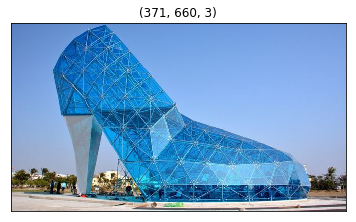

In [19]:
# content image
visualize_image('glass_church.jpg')

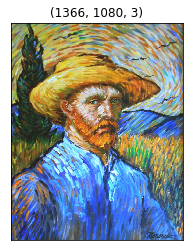

In [20]:
# style image
visualize_image('oil.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 15664421000.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 578s
Start of iteration 1
Current loss value: 7963560000.0
Iteration 1 completed in 625s
Start of iteration 2
Current loss value: 5666012700.0
Iteration 2 completed in 619s
Start of iteration 3
Current loss value: 4539693600.0
Iteration 3 completed in 590s
Start of iteration 4
Current loss value: 3777129700.0
Iteration 4 completed in 591s
Start of iteration 5
Current loss value: 3301883000.0
Iteration 5 completed in 580s
Start of iteration 6
Current loss value: 2931920600.0
Iteration 6 completed in 583s
Start of iteration 7
Current loss value: 2705411000.0
Iteration 7 completed in 587s
Start of iteration 8
Current loss value: 2499573000.0
Iteration 8 completed in 705s
Start of iteration 9
Current loss value: 2352797000.0
Iteration 9 completed in 916s


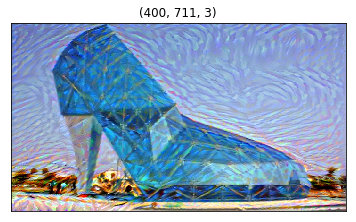

In [21]:
save_weights_path = 'save_model/Voil_model_weights.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 0.005 
    - TV_WEIGHT = 0.01
    
transfer style: **doodle art**

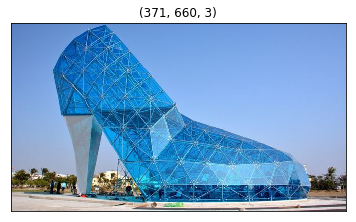

In [76]:
# content image
visualize_image('glass_church.jpg')

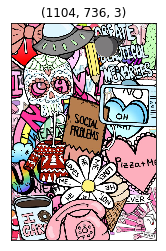

In [53]:
# style image
visualize_image('doodle2.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 1796433300.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 615s
Start of iteration 1
Current loss value: 1032524800.0
Iteration 1 completed in 697s
Start of iteration 2
Current loss value: 772682200.0
Iteration 2 completed in 731s
Start of iteration 3
Current loss value: 655369200.0
Iteration 3 completed in 711s
Start of iteration 4
Current loss value: 592771100.0
Iteration 4 completed in 703s
Start of iteration 5
Current loss value: 555026500.0
Iteration 5 completed in 706s
Start of iteration 6
Current loss value: 525906700.0
Iteration 6 completed in 753s
Start of iteration 7
Current loss value: 505293570.0
Iteration 7 completed in 713s
Start of iteration 8
Current loss value: 488754720.0
Iteration 8 completed in 750s
Start of iteration 9
Current loss value: 475935940.0
Iteration 9 completed in 764s


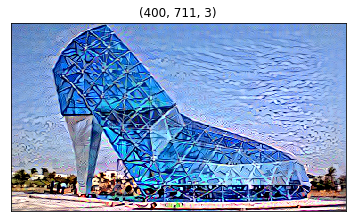

In [49]:
save_weights_path = 'save_model/Vdoodle_model_weights.hdf5'
train(save_weights_path)

## Retrain the model

1. Reload the saved model weights
2. Change the start image to the image we wants to keep training

In [50]:
model.load_weights('save_model/Vdoodle_model_weights.hdf5')

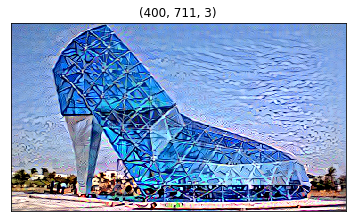

In [51]:
START_IMG_PATH = 'previous_img.png'
visualize_image(START_IMG_PATH)

### || Glass Church - iteration 11-20 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 0.005 
    - TV_WEIGHT = 0.01

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 549088060.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 787s
Start of iteration 1
Current loss value: 485863800.0
Iteration 1 completed in 777s
Start of iteration 2
Current loss value: 464107840.0
Iteration 2 completed in 708s
Start of iteration 3
Current loss value: 447230400.0
Iteration 3 completed in 737s
Start of iteration 4
Current loss value: 436039100.0
Iteration 4 completed in 779s
Start of iteration 5
Current loss value: 427905200.0
Iteration 5 completed in 681s
Start of iteration 6
Current loss value: 421556900.0
Iteration 6 completed in 710s
Start of iteration 7
Current loss value: 416358400.0
Iteration 7 completed in 770s
Start of iteration 8
Current loss value: 411942100.0
Iteration 8 completed in 760s
Start of iteration 9
Current loss value: 408172060.0
Iteration 9 completed in 708s


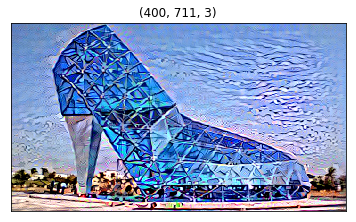

In [52]:
save_weights_path = 'save_model/Vdoodle_model_weights_20.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 1 
    - STYLE_WEIGHT = 2
    - TV_WEIGHT = 0.1
    
 transfer style: **sketch**

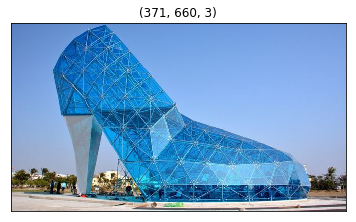

In [75]:
# content image
visualize_image('glass_church.jpg')

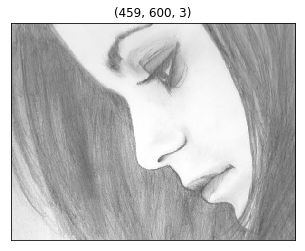

In [72]:
# style image
visualize_image('face_sketch.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 3826996200.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 639s
Start of iteration 1
Current loss value: 1623805700.0
Iteration 1 completed in 641s
Start of iteration 2
Current loss value: 1046872100.0
Iteration 2 completed in 712s
Start of iteration 3
Current loss value: 799741900.0
Iteration 3 completed in 788s
Start of iteration 4
Current loss value: 680152450.0
Iteration 4 completed in 734s
Start of iteration 5
Current loss value: 602155200.0
Iteration 5 completed in 638s
Start of iteration 6
Current loss value: 552973440.0
Iteration 6 completed in 637s
Start of iteration 7
Current loss value: 519203000.0
Iteration 7 completed in 653s
Start of iteration 8
Current loss value: 494066180.0
Iteration 8 completed in 638s
Start of iteration 9
Current loss value: 473389900.0
Iteration 9 completed in 659s


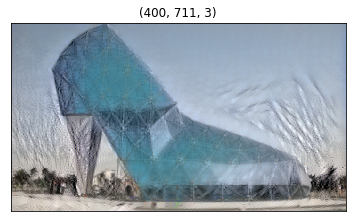

In [277]:
save_weights_path = 'save_model/Vsketch_model_weights.hdf5'
train(save_weights_path)

## Reference

1. [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
2. [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)